In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import pandas as pd
from google.colab import files
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso, ElasticNet 
from sklearn.preprocessing import StandardScaler, MinMaxScaler
uploaded = files.upload()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
data_train = pd.read_csv('./train.csv')

In [4]:
data_train.head()


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
data_train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [6]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

# **1. Przegląd i analiza datasetu**
Najważniejszą czynnością, którą musimy wykonać przy analizie datasetu 
www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python
jest zrozumienie znaczenia każdej zmiennej. Pytania, które musimy sobie zdać to określić, czy dana zmienna dotyczy samego budynku, jego przestrzeni oraz lokalizacji czy sąsiedztwa. Warto odpowiedzieć na pytanie w jaki sposób dana zmienna wpływa na cene domu oraz jak ważna jest ta zmienna. 
Możemy też przeanalizować, czy dana informacja jest już opisana za pomocą jakiejś innej zmiennej (np. jeśli "LandContour" informuje o płaskości nieruchomości, to czy naprawdę musimy znać nachylenie terenu "LandSlope"?).
Po krótkiej analizie możemy zauważyć, że zmienne, które wydają się mieć duży wpływ na nasz problem to:
*   OverallQual - ocenia cały materiał i wykończenie domu, bardzo ważna zmienna, nie mamy konkretnych informacji w jaki sposób jest wyliczona
*   YearBuilt - data budowy
*   TotalBsmtSF - powierzchnia piwnicy
*   GrLivArea - powierzchnia mieszkalna
Spodziewałem się, że zmienna "Neigborhood" będzie bardziej istotna, ale po zbadaniu danych skończyłem z jej wyłączeniem. 




In [7]:
data_train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

Świetnie, minimalna cena jest większa od zera, co znacząco ułatwi nam analizę.

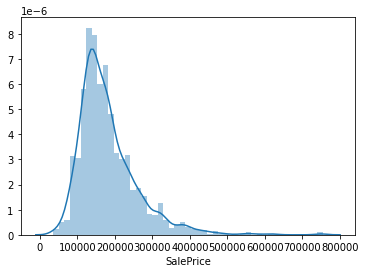

In [8]:
sns.distplot(data_train['SalePrice']);

In [9]:
print("Skewness: %f" % data_train['SalePrice'].skew())
print("Kurtosis: %f" % data_train['SalePrice'].kurt())

Skewness: 1.882876
Kurtosis: 6.536282


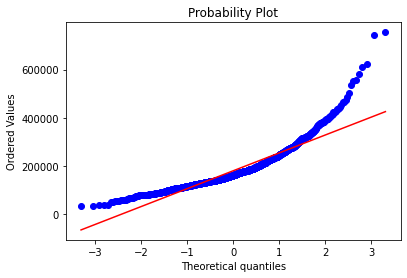

In [10]:
fig = plt.figure()
stats.probplot(data_train['SalePrice'], plot=plt)
plt.show()

# Analiza korelacji zmiennej 'SalePrice' z innymi kluczowymi zmiennymi

Na początku sprawdźmy zajmiemy się zmiennymi dotyczącymi powierzchni piwnicy oraz powierzchni mieszkalnej.

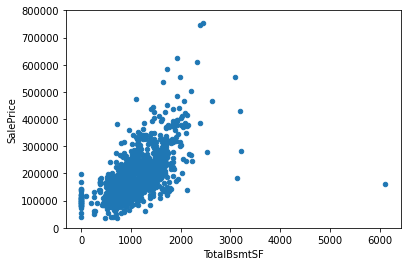

In [11]:
var = 'TotalBsmtSF'
data = pd.concat([data_train['SalePrice'], data_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

**Teraz analiza powierzchni mieszkalnej**

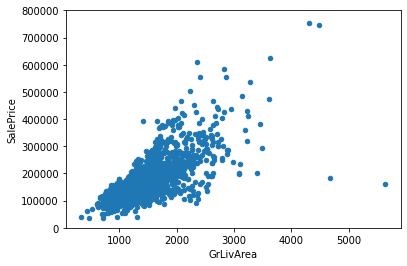

In [12]:
var = 'GrLivArea'
data = pd.concat([data_train['SalePrice'], data_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

Dla mnie to całkiem zaskakujące, powierzchnia piwnicy ma większy (silnie liniowy) wpływ na cene mieszkania niż powierzchnia mieszkania (korelacja liniowa). Niemniej jednak obie informacje mają znaczący wpływ na cene domu.

**Teraz przyjrzymy się takim zmiennym jak 'OverallQual' czyli ogolnej ocenie wykonczenia domu w skali 1-10 oraz 'YearBuilt' czyli dacie budowy**

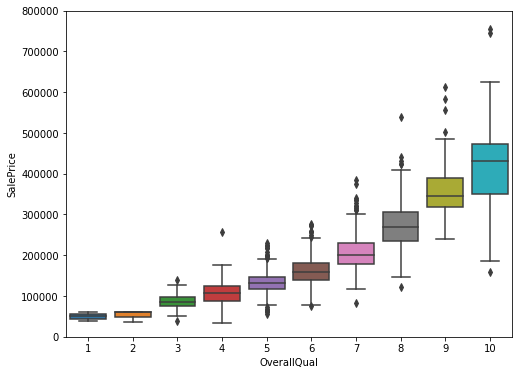

In [13]:
var = 'OverallQual'
data = pd.concat([data_train['SalePrice'], data_train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

Widzmy bardzo silną zależność między jakością mieszkania a ceną.

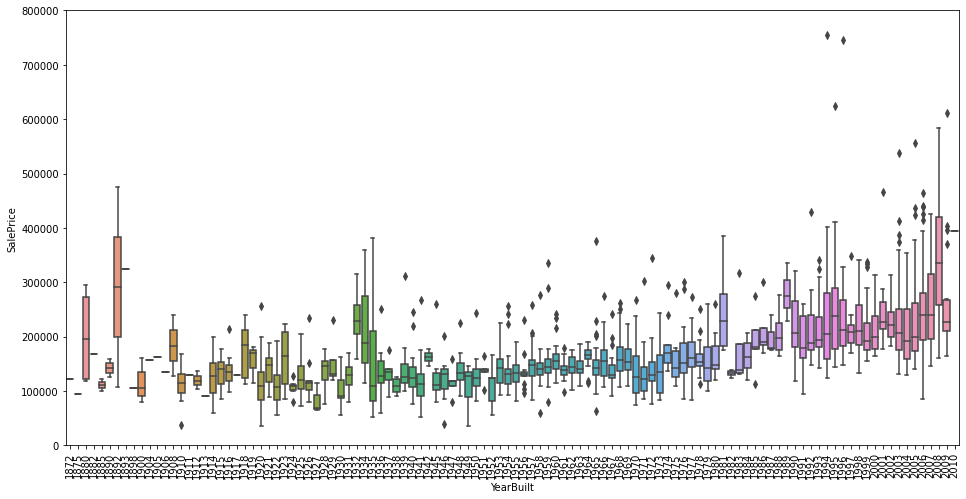

In [14]:
var = 'YearBuilt'
data = pd.concat([data_train['SalePrice'], data_train[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);
plt.xticks(rotation=90);

Tutaj zależnośc nie jest tak silna, ale też widać, że im mieszkanie nowsze tym droższe.

**Podsumowujac:** GrLivArea" i "TotalBsmtSF" wydają się być liniowo powiązane z "SalePrice". Obie zależności są pozytywne, co oznacza, że w miarę jak jedna zmienna rośnie, druga również rośnie. W przypadku 'TotalBsmtSF' widzimy, że nachylenie relacji liniowej jest szczególnie wysokie.
TotalQual" i "YearBuilt" również wydają się być związane z "SalePrice". Zależność ta wydaje się być silniejsza w przypadku "OverallQual", gdzie wykres słupkowy pokazuje, jak ceny sprzedaży rosną wraz z ogólną jakością.

Jednak teraz koniec z analizą związaną z naszą intuicją, do teraz będziemy posługiwać się czysto inżynierskim podejściem.


**Na wczesniejszych wykresach moglismy zauwazyc, ze nasza zmienna 'SalePrice' jest odpowiednio pochylona. Teraz musimy przetransformować tę zmienną i uczynić ją normalnym rozkładem.**

In [0]:
#applying log transformation
data_train['SalePrice'] = np.log1p(data_train['SalePrice'])

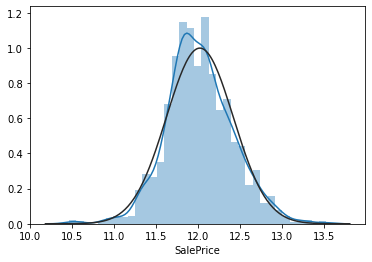

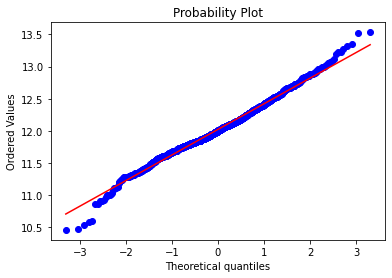

In [16]:
#transformed histogram and normal probability plot
sns.distplot(data_train['SalePrice'], fit=stats.norm);
fig = plt.figure()
res = stats.probplot(data_train['SalePrice'], plot=plt)

**HeatMap**

Najlepszym sposobem to zapoznania się z omawianymi danymi jest heatmapa.
Mozemy zauwazyc dwa czerwone kwadraty, które przyciągają uwagę. Pierwszy z nich odnosi się do zmiennych **'TotalBsmtSF'** i **'1stFlrSF'**, a drugi do zmiennych **'GarageX'**. Oba przypadki pokazują jak istotna jest korelacja pomiędzy tymi zmiennymi. Jeśli zastanowimy się nad tymi zmiennymi, możemy stwierdzić, że dają one prawie te same informacje.

Kolejną rzeczą, która zwraca moją uwagę są korelacje **"SalePrice"**. Widzimy nasze dobrze znane **"GrLivArea", "TotalBsmtSF" i "OverallQual"**, ale widzimy też wiele innych zmiennych, które powinny być brane pod uwagę.


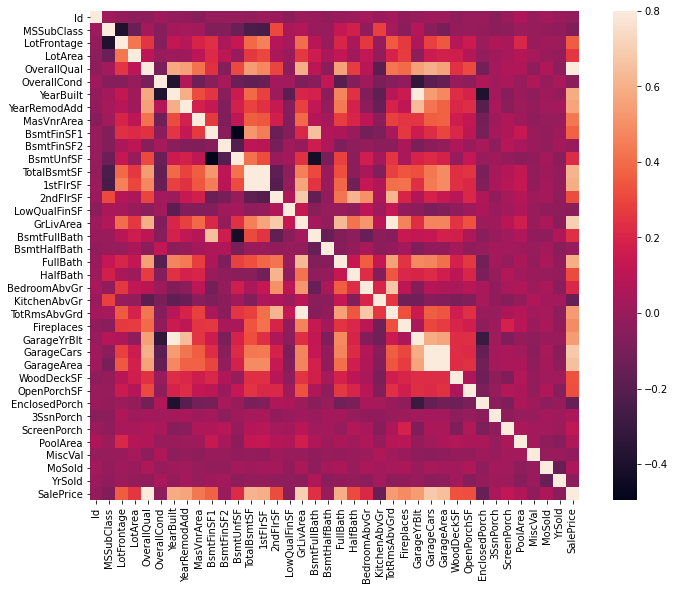

In [17]:
corrmat = data_train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

**Teraz sprawdzmy zmienne, które korelują > 50%**

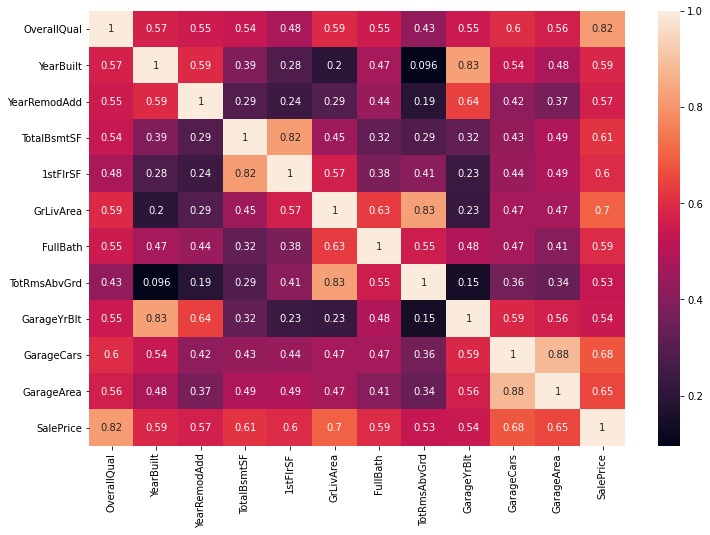

In [18]:
top_feature = corrmat.index[abs(corrmat['SalePrice'] > 0.5)]
plt.subplots(figsize=(12, 8))
top_corr = data_train[top_feature].corr()
sns.heatmap(top_corr, annot=True)
plt.show()

 

*  GarageCars" i "GarageArea" są  jednymi z najsilniej skorelowanych zmiennych, jednak liczba samochodow ktore mieszcza sie w garazu jest dla nas podobna informacja, jak rozmiar garazu - wiec uwazam, ze potrzebujemy tylko jeden z tych zmiennych dla naszej dalszej analizy - zostawimy zmienna z wyzsza korelacja
*  TotalBsmtSF" i "1stFloor" również sa podobne. Możemy zachować 'TotalBsmtSF'
*   Jesli chodzi o FullBath to nie wiem co napisac XD
*   "TotRmsAbvGrd" i "GrLivArea" znowu podobne zmienne 
*   "YearBuilt" i "YearRemodAdd" rok budowy oraz data ostatniego remontu wedlug naszych oczekiwan mają korelacje z ceną
*   "OverallQual" - o tej zmiennej juz pisalismy sporo wczesniej, "jedyna", ale jakze wazna rzecza ktora jest w niej niewlasciwa, to niewiadomo w jaki spsosob zostala policzona, widac tez ze jest wysoko skorelowana z innymi zmiennymi




**Wykresy rozproszenia pomiędzy "SalePrice" a skorelowanymi zmiennymi**

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:2071: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


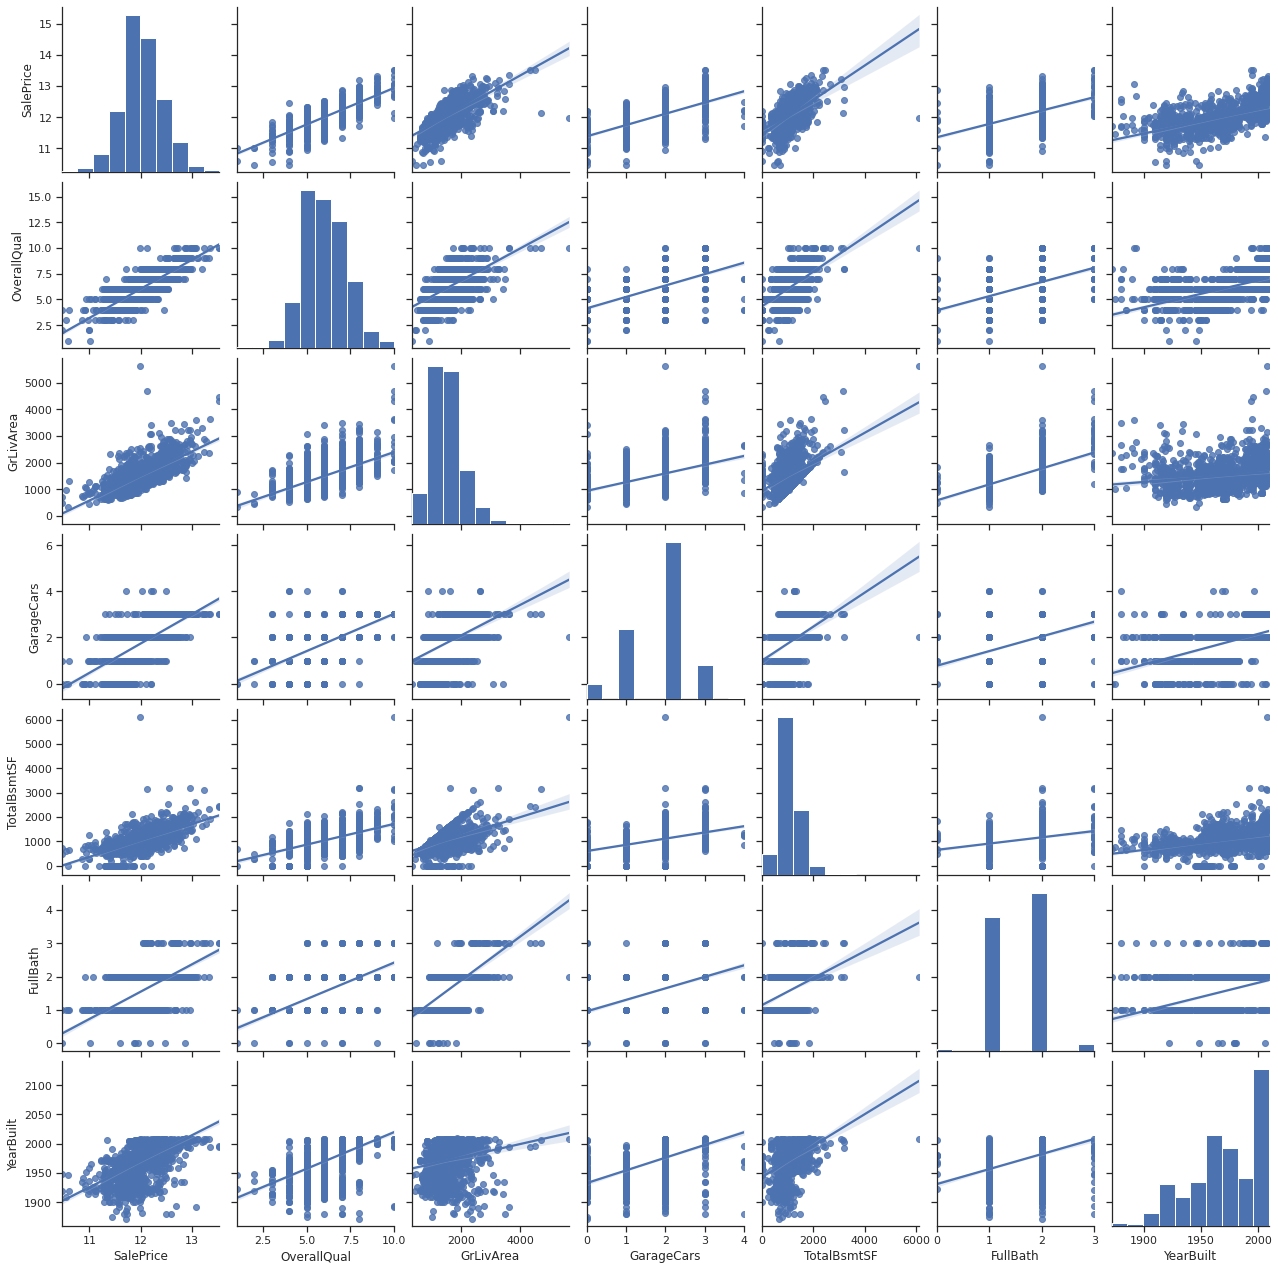

In [19]:
sns.set(style='ticks')
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(data_train[cols], size = 2.5, kind="reg")

# **2. Analiza i obsługa brakujących wartości**

Najważniejsze pytania, na które chcemy uzyskać odpowiedź to:

Jaka jest częstostotliwosc występowania brakujących danych?
Czy brakujące dane są przypadkowe, czy też mają jakiś wzór?

In [20]:
data_train.columns[data_train.isnull().any()]

Index(['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence',
       'MiscFeature'],
      dtype='object')

In [21]:
total = data_train.isnull().sum().sort_values(ascending=False)
percent = (data_train.isnull().sum()/data_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageCond,81,0.055479
GarageType,81,0.055479
GarageYrBlt,81,0.055479
GarageFinish,81,0.055479


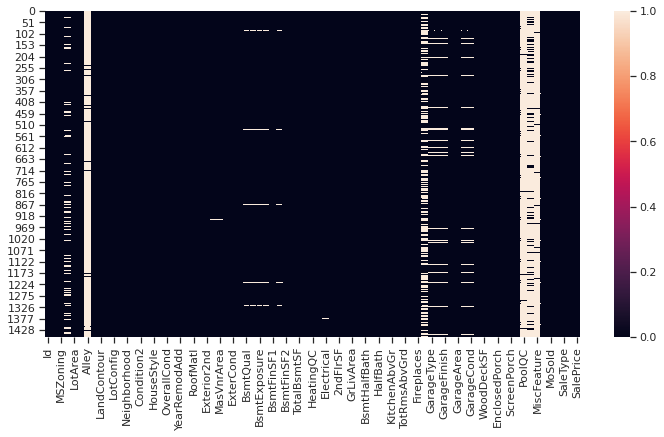

In [22]:
plt.figure(figsize=(12, 6))
sns.heatmap(data_train.isnull())
plt.show()

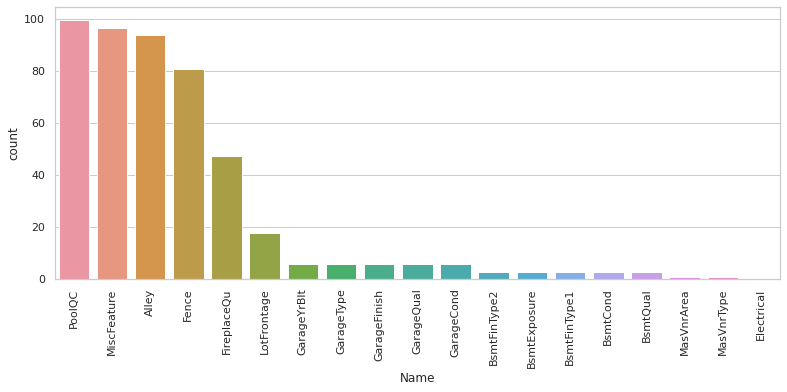

In [23]:
Isnull = data_train.isnull().sum()/len(data_train)*100
Isnull = Isnull[Isnull>0]
Isnull.sort_values(inplace=True, ascending=False)
Isnull = Isnull.to_frame()
Isnull.columns = ['count']
Isnull.index.names = ['Name']
Isnull['Name'] = Isnull.index
plt.figure(figsize=(13, 5))
sns.set(style='whitegrid')
sns.barplot(x='Name', y='count', data=Isnull)
plt.xticks(rotation = 90)
plt.show()

**Kolumny, ktore maja najwiecej missing value ustawiamy jako None, jak nie ma o czyms informacji, uznajemy, ze tego nie ma, albo jest tak slabe ze w ogloszeniu nie warto bylo o tym wspomniec - takie podejscie zapewnia lepsze wyniki niz ignorowanie tych danych**

In [0]:
data_train["PoolQC"] = data_train["PoolQC"].fillna("None")
data_train['MiscFeature'] = data_train['MiscFeature'].fillna('None')
data_train['Alley'] = data_train['Alley'].fillna('None')
data_train['Fence'] = data_train['Fence'].fillna('None')
data_train['FireplaceQu'] = data_train['FireplaceQu'].fillna('None')

**Zmienna LotFrontage pogrupujemy według dzielnic i uzupełnimy brakującą wartość przez medianę LotFrontage wszystkich dzielnic**

In [0]:
data_train['LotFrontage'] = data_train.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

**Pozostale brakujace wartosci w poszczegolnych kolumnach ustawiamy odpowiednio na null lub zero**

In [0]:
for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    data_train[col] = data_train[col].fillna('None')
for col in ['GarageYrBlt', 'GarageArea', 'GarageCars']:
    data_train[col] = data_train[col].fillna(int(0))
for col in ('BsmtFinType2', 'BsmtExposure', 'BsmtFinType1', 'BsmtCond', 'BsmtQual'):
    data_train[col] = data_train[col].fillna('None')
data_train['MasVnrArea'] = data_train['MasVnrArea'].fillna(int(0))
data_train['MasVnrType'] = data_train['MasVnrType'].fillna('None')

**Utilities:** Dla tej kategorycznej kolumny wszystkie rekordy to "AllPub", z wyjątkiem jednego "NoSeWa" i 2 NA . Ponieważ dom z "NoSewa" jest w zestawie treningowym, funkcja ta nie pomoże w modelowaniu predykcyjnym.

In [0]:
data_train = data_train.drop(['Utilities'], axis=1)

**Electrical:** Ma jedną wartość NA, modą jest 'SBrkr', więc ustawimy ją dla jednej brakującej wartości.

In [0]:
data_train['Electrical'] = data_train['Electrical'].fillna(data_train['Electrical']).mode()[0]

**Sprawdźmy czy mamy jakąś brakującą wartość**

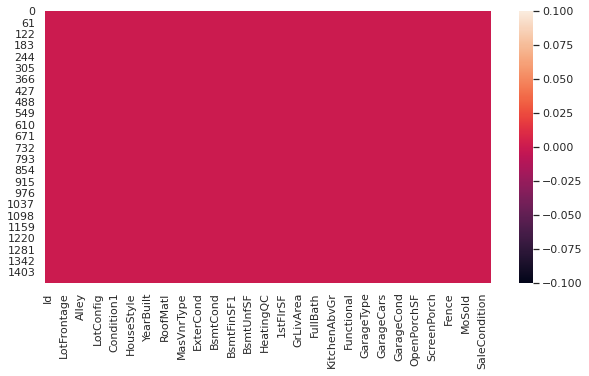

In [29]:
plt.figure(figsize=(10, 5))
sns.heatmap(data_train.isnull())

**Teraz nie mamy żadnych żadnych brakujących danych**

Usuwamy dummy values

In [0]:
# data_train = pd.get_dummies(data_train)

In [0]:
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold', 'MSZoning', 'LandContour', 'LotConfig', 'Neighborhood',
        'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
        'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'Foundation', 'GarageType', 'MiscFeature', 
        'SaleType', 'SaleCondition', 'Electrical', 'Heating')

In [0]:
from sklearn.preprocessing import LabelEncoder
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(data_train[c].values)) 
    data_train[c] = lbl.transform(list(data_train[c].values))

**Przygotowanie danych do uzycia regresji**

In [0]:
y = data_train['SalePrice']
del data_train['SalePrice']
X = data_train.values
y = y.values

# podzielenie danych na dwa zbiory testowy i treningowy
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

# Regresja liniowa z GridSearchCV

In [33]:
param_grid = {
    'fit_intercept':[True,False], 
    'normalize':[True,False], 
    'copy_X':[True, False]
}

#training_scores_encoded = LabelEncoder().fit_transform(y_train)

grid_LinearRegression = GridSearchCV(LinearRegression(), param_grid, scoring='r2', cv=3, n_jobs=-1, return_train_score=True, verbose=1000)

grid_LinearRegression.fit(X_train, y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1821s

GridSearchCV(cv=3, error_score=nan,
             estimator=LinearRegression(copy_X=True, fit_intercept=True,
                                        n_jobs=None, normalize=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'copy_X': [True, False],
                         'fit_intercept': [True, False],
                         'normalize': [True, False]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='r2', verbose=1000)

In [34]:
grid_LinearRegression.best_params_

{'copy_X': True, 'fit_intercept': False, 'normalize': True}

In [0]:
train_predict = np.expm1(grid_LinearRegression.predict(X_train))
test_predict = np.expm1(grid_LinearRegression.predict(X_test))

In [36]:
print("Accuracy --> ", grid_LinearRegression.score(X_test, y_test)*100)

Accuracy -->  88.769038302433


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


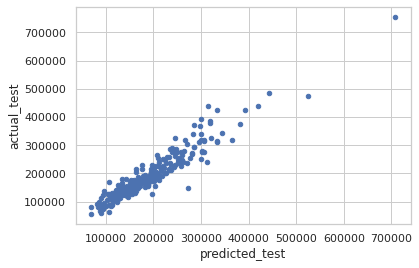

In [37]:
test_real = np.expm1(y_test)
train_real = np.expm1(y_train)

predictions = pd.DataFrame({"predicted_test":test_predict, "actual_test":test_real})
predictions.plot(x = "predicted_test", y = "actual_test", kind = "scatter")

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


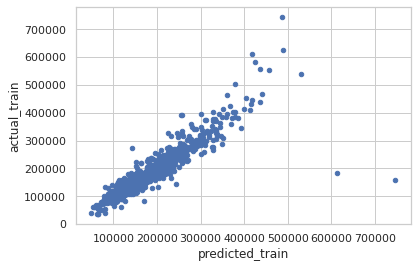

In [38]:
predictions = pd.DataFrame({"predicted_train":train_predict, "actual_train":train_real})
predictions.plot(x = "predicted_train", y = "actual_train", kind = "scatter")

# RandomForestRegressor with GridSearchCV

In [0]:
from sklearn.ensemble import RandomForestRegressor

In [40]:
param_grid={"n_estimators": [1, 5, 10, 20, 30, 40, 50, 100],
            "max_features": ["auto", "sqrt", "log2"],
            "min_samples_split": [2, 4, 8, 16],
            "bootstrap": [True, False],
}

grid_RandomForestRegressor = GridSearchCV(RandomForestRegressor(), param_grid, scoring='r2', cv=3, n_jobs=-1, return_train_score=True, verbose=1000)

grid_RandomForestRegressor.fit(X_train, y_train)

Fitting 3 folds for each of 192 candidates, totalling 576 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0658s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  22 ta

GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [41]:
grid_RandomForestRegressor.best_params_

{'bootstrap': False,
 'max_features': 'sqrt',
 'min_samples_split': 2,
 'n_estimators': 100}

In [0]:
train_predict_rf = np.expm1(grid_RandomForestRegressor.predict(X_train))
test_predict_rf = np.expm1(grid_RandomForestRegressor.predict(X_test))

In [43]:
print("Accuracy --> ", grid_RandomForestRegressor.score(X_test, y_test)*100)

Accuracy -->  87.90393406815974


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


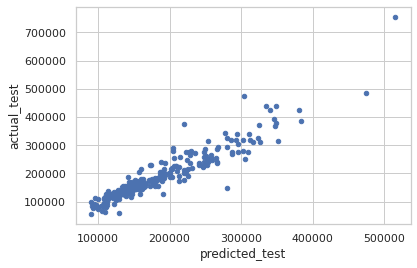

In [44]:
predictions = pd.DataFrame({"predicted_test":test_predict_rf, "actual_test":test_real})
predictions.plot(x = "predicted_test", y = "actual_test", kind = "scatter")

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


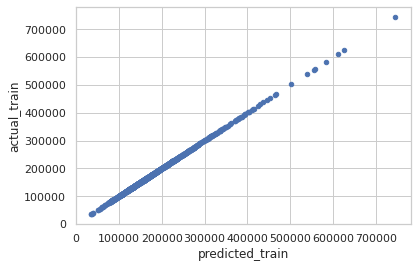

In [45]:
predictions = pd.DataFrame({"predicted_train":train_predict_rf, "actual_train":train_real})
predictions.plot(x = "predicted_train", y = "actual_train", kind = "scatter")

**LinearRegression vs RandomForestRegression**

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


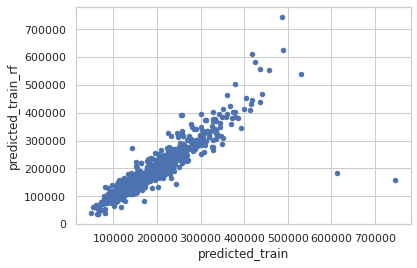

In [46]:
predictions = pd.DataFrame({"predicted_train_rf":train_predict_rf, "predicted_train":train_predict})
predictions.plot(x = "predicted_train", y = "predicted_train_rf", kind = "scatter")

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


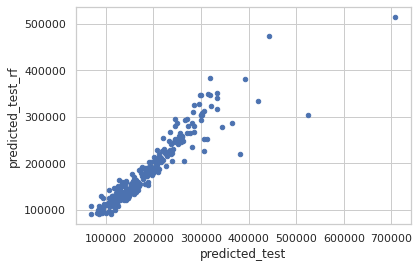

In [47]:
predictions = pd.DataFrame({"predicted_test_rf":test_predict_rf, "predicted_test":test_predict})
predictions.plot(x = "predicted_test", y = "predicted_test_rf", kind = "scatter")

# GradientBoostingRegressor

In [0]:
from sklearn.ensemble import GradientBoostingRegressor
GBR = GradientBoostingRegressor(n_estimators=100, max_depth=4)

In [49]:
GBR.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=4,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [0]:
train_predict_gbr = np.expm1(GBR.predict(X_train))
test_predict_gbr = np.expm1(GBR.predict(X_test))

In [51]:
print("Accuracy --> ", GBR.score(X_test, y_test)*100)

Accuracy -->  91.77129948494537


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


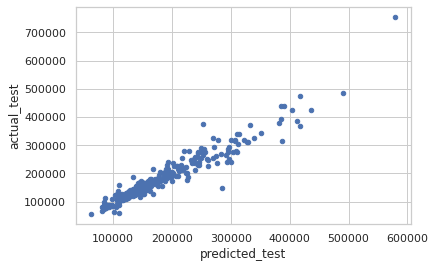

In [52]:
predictions = pd.DataFrame({"predicted_test":test_predict_gbr, "actual_test":test_real})
predictions.plot(x = "predicted_test", y = "actual_test", kind = "scatter")

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


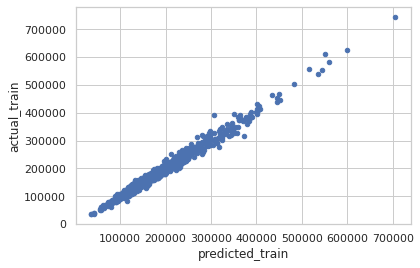

In [53]:
predictions = pd.DataFrame({"predicted_train":train_predict_gbr, "actual_train":train_real})
predictions.plot(x = "predicted_train", y = "actual_train", kind = "scatter")

**Porownanie z regresja liniowa**

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


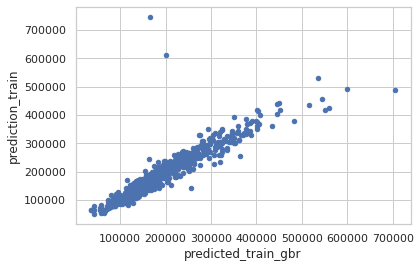

In [54]:
predictions = pd.DataFrame({"predicted_train_gbr":train_predict_gbr, "prediction_train":train_predict})
predictions.plot(x = "predicted_train_gbr", y = "prediction_train", kind = "scatter")

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


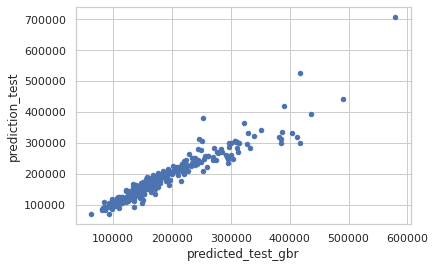

In [55]:
predictions = pd.DataFrame({"predicted_test_gbr":test_predict_gbr, "prediction_test":test_predict})
predictions.plot(x = "predicted_test_gbr", y = "prediction_test", kind = "scatter")

# XGBRegressor z GridSearchCV

In [56]:
import xgboost
XGBRegressor = xgboost.XGBRegressor()
param_grid = {'n_estimators': [100, 150, 200],
              'learning_rate': [0.01, 0.05, 0.1], 
              'max_depth': [3, 4, 5, 6, 7]}

grid_XGBRegressor = GridSearchCV(XGBRegressor, param_grid, scoring='r2', cv=3, n_jobs=-1, return_train_score=True, verbose=1000)

grid_XGBRegressor.fit(X_train, y_train)

Fitting 3 folds for each of 45 candidates, totalling 135 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   

GridSearchCV(cv=3, error_score=nan,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objective='reg:linear', random_state=0,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 4, 5, 6, 7],
                  

In [57]:
grid_XGBRegressor.best_params_

{'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200}

In [0]:
train_predict_xgb = np.expm1(grid_XGBRegressor.predict(X_train))
test_predict_xgb = np.expm1(grid_XGBRegressor.predict(X_test))

In [59]:
print("Accuracy --> ", grid_XGBRegressor.score(X_test, y_test)*100)

Accuracy -->  91.0592598621521


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


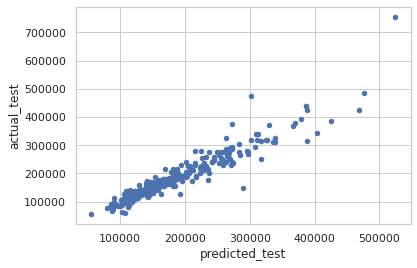

In [60]:
predictions = pd.DataFrame({"predicted_test":test_predict_xgb, "actual_test":test_real})
predictions.plot(x = "predicted_test", y = "actual_test", kind = "scatter")

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


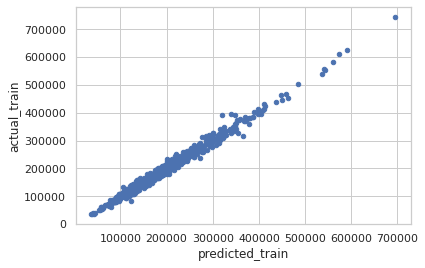

In [61]:
predictions = pd.DataFrame({"predicted_train":train_predict_xgb, "actual_train":train_real})
predictions.plot(x = "predicted_train", y = "actual_train", kind = "scatter")

**Porownanie kolejno z innymi modelami**

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


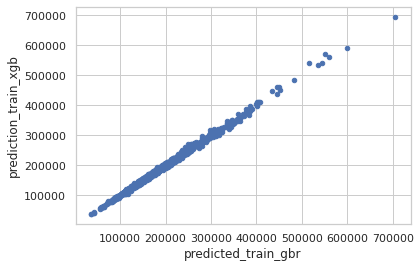

In [62]:
predictions = pd.DataFrame({"predicted_train_gbr":train_predict_gbr, "prediction_train_xgb":train_predict_xgb})
predictions.plot(x = "predicted_train_gbr", y = "prediction_train_xgb", kind = "scatter")

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


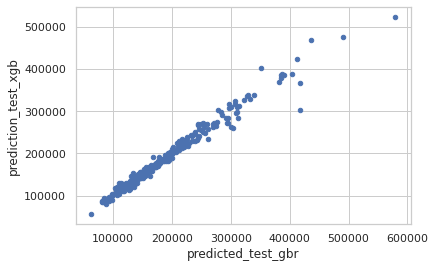

In [63]:
predictions = pd.DataFrame({"predicted_test_gbr":test_predict_gbr, "prediction_test_xgb":test_predict_xgb})
predictions.plot(x = "predicted_test_gbr", y = "prediction_test_xgb", kind = "scatter")

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


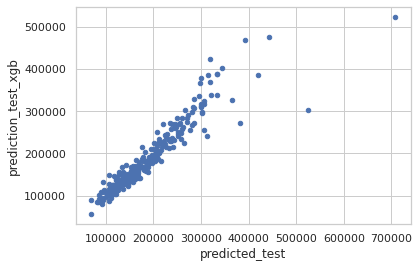

In [64]:
predictions = pd.DataFrame({"predicted_test":test_predict, "prediction_test_xgb":test_predict_xgb})
predictions.plot(x = "predicted_test", y = "prediction_test_xgb", kind = "scatter")

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


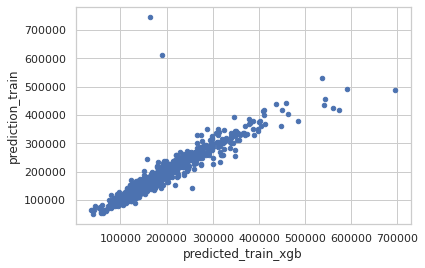

In [65]:
predictions = pd.DataFrame({"predicted_train_xgb":train_predict_xgb, "prediction_train":train_predict})
predictions.plot(x = "predicted_train_xgb", y = "prediction_train", kind = "scatter")

In [66]:
results = pd.DataFrame({
    'algorithm':['linear regression', 'random forest regression', 'gbr regressor', 'xgb regressor'],
    'train accuracy': [grid_LinearRegression.score(X_train, y_train)*100, grid_RandomForestRegressor.score(X_train, y_train)*100, GBR.score(X_train, y_train)*100, grid_XGBRegressor.score(X_train, y_train)*100],
    'test accuracy': [grid_LinearRegression.score(X_test, y_test)*100, grid_RandomForestRegressor.score(X_test, y_test)*100, GBR.score(X_test, y_test)*100, grid_XGBRegressor.score(X_test, y_test)*100]})
results


,algorithm,train accuracy,test accuracy
0,linear regression,87.549923,88.769038
1,random forest regression,100.000000,87.903934
2,gbr regressor,98.057623,91.771299
3,xgb regressor,98.267562,91.059260


# Artificial Neural Network Implementation

In [34]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LeakyReLU,PReLU,ELU
from keras.layers import Dropout
from keras.callbacks import History

model_1 = Sequential()
model_1.add(Dense(50, init = 'he_uniform', input_shape=(X_train.shape[1],), activation='relu'))
model_1.add(Dense(25, init = 'he_uniform',activation='relu'))
model_1.add(Dense(50, init = 'he_uniform', activation='relu'))
model_1.add(Dense(1, init = 'he_uniform'))

# Compiling the model
model_1.compile(loss='mean_squared_error',
            optimizer='Adamax',
            metrics=['mean_squared_error'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(50, input_shape=(79,), activation="relu", kernel_initializer="he_uniform")`
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(25, activation="relu", kernel_initializer="he_uniform")`
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(50, activation="relu", kernel_initializer="he_uniform")`
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, kernel_initializer="he_uniform")`
  if sys.path[0] == '':


In [35]:
model_1.fit(X_train,y_train, validation_data= (X_test, y_test),epochs=1000, batch_size=256)

Train on 1168 samples, validate on 292 samples
Epoch 1/1000
1168/1168 [==============================] - 0s 116us/step - loss: 4685745.4058 - mean_squared_error: 4685745.0000 - val_loss: 5518958.1969 - val_mean_squared_error: 5518958.0000
Epoch 2/1000
1168/1168 [==============================] - 0s 17us/step - loss: 1105899.8724 - mean_squared_error: 1105899.8750 - val_loss: 1919347.2873 - val_mean_squared_error: 1919347.2500
Epoch 3/1000
1168/1168 [==============================] - 0s 16us/step - loss: 214487.7574 - mean_squared_error: 214487.7656 - val_loss: 537462.8137 - val_mean_squared_error: 537462.8125
Epoch 4/1000
1168/1168 [==============================] - 0s 16us/step - loss: 119910.7104 - mean_squared_error: 119910.7109 - val_loss: 125444.9302 - val_mean_squared_error: 125444.9297
Epoch 5/1000
1168/1168 [==============================] - 0s 16us/step - loss: 49704.5886 - mean_squared_error: 49704.5859 - val_loss: 34472.4745 - val_mean_squared_error: 34472.4766
Epoch 6/1000


In [0]:
train_predict_nn_l1 = model_1.predict(X_train)
test_predict_nn_l2 = model_1.predict(X_test)

In [37]:
model_1.evaluate(X_test,y_test)

292/292 [==============================] - 0s 51us/step


[1298.8741529355311, 1298.8741455078125]